# Universal differential equation for the SIR model

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behavior
rng = StableRNG(1);

### 1. Define the SIR model and sample one data set

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ode = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0)

prob = ODEProblem(sir!, u0, tspan, p_ode)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

In [3]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.05)
noise = rand(rng, dist, size(X[:, begin:4:end]))
X_noisy = noise .* X[:, begin:4:end];

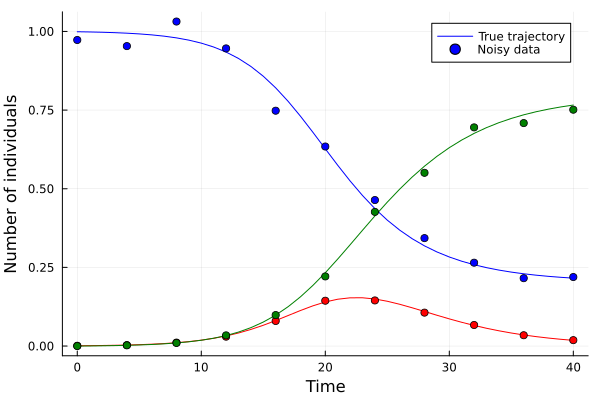

In [4]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = [:blue :red :green], label = ["True trajectory" nothing nothing])
scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])

### 2. Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \gamma)+\text{NN}(u, \theta)$.

In [5]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [6]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p.nn, st)[1]  
    du[1] = nn[1]
    du[2] = -p.γ*u[2] + nn[2] 
    du[3] = p.γ*u[2] + nn[3]
end

γ_init = 0.1
p_init = (nn = θ_init, γ = γ_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### 3. Set up the training

In [7]:
function predict(p, saveat = t[begin:4:end])   # p contains NN parameters θ and mechanistic parameter γ of the ODE
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

\$ \sum_i\int_0^T|\text{NN}_i(x(t),\theta)| dt $ 

\$ \approx\sum_{n=0}^{N-1}\sum_i(t_{n+1}-t_n)|\text{NN}_i(x(t_n),\theta)|$

In [8]:
function loss(x, p)   # x: optimized variable, p: parametrization of the objective
    if p.reg == nothing
        X̂ = predict(x)
        mean(abs2, X_noisy .- X̂)   
    elseif p.reg == "L2 θ"
        X̂ = predict(x)
        mean(abs2, X_noisy .- X̂) + p.ω * norm(x.nn)
    elseif p.reg == "L2 θ advanced"
        X̂ = predict(x)
        if size(X̂) == size(X_noisy)           
            mean(abs2, X_noisy .- X̂) + p.ω * norm(x.nn)
        else
            Inf
        end  
    elseif p.reg == "Integral"
        X̂_fine = predict(x, t)
        X̂ = X̂_fine[:, begin:4:end]
        mean(abs2, X_noisy .- X̂) + p.ω * norm(Lux.apply(model, X̂_fine[:, begin:end-1], x.nn, st)[1], 1)
    end
end;

### 4. Method to train the UDE using different regularization techniques

In [9]:
function train_ude(reg, ω, adam_epochs = 7500, bfgs_epochs = 7500, print_loss = false)
    # Set up histories for loss and parameter estimates
    losses = Float64[]
    γ_hist = Float64[]
    function callback(p, l)
        push!(losses, l)
        push!(γ_hist, p.γ)
        if print_loss
            n_iter = length(losses)
            if n_iter % 250 == 0   
                println("Loss after $(n_iter) iterations: $(losses[end])")
            end
        end
        return false
    end
    
    # Set up optimization problem
    adtype = AutoZygote()
    optf = OptimizationFunction(loss, adtype)
    optprob = OptimizationProblem(optf, p_init, (reg = reg, ω = ω))
    
    # Hybrid training procedure combining Adam and BFGS
    if print_loss
        println("Using Adam:")
    end
    res1 = solve(optprob, ADAM(), callback = callback, maxiters = adam_epochs)
    optprob2 = OptimizationProblem(optf, res1.u, (reg = reg, ω = ω))
    if print_loss
        println("Using BFGS:")
    end
    res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = bfgs_epochs)
    p_trained = res2.u;
    
    return [reg, ω, adam_epochs, losses, γ_hist, p_trained]    
end;

### 5. Method to visualize the results

In [10]:
function nrmse(y_true, y_pred)
    mse = mean(abs2, y_pred .- y_true)
    rmse = sqrt(mse)
    nrmse = rmse / (maximum(y_true) - minimum(y_true))
    return nrmse
end;

In [11]:
function visualize(result)  
    # Unpack result
    reg, ω, adam_epochs, losses, γ_hist, p_trained = result    
    
    # Print type of regularization and estimated mechanistic parameter
    println("Regularization: $(reg), ω: $(ω)")
    println("Estimate of γ: $(p_trained.γ)")
    
    # Convergence plot
    p1 = plot(1:adam_epochs, losses[1:adam_epochs], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM",
              color=:blue)
    plot!(adam_epochs+1:length(losses), losses[adam_epochs+1:end], yaxis=:log10, label="BFGS", color=:red)
    
    # Parameter estimate plot
    p2 = plot(1:adam_epochs, γ_hist[1:adam_epochs], xlabel="Iterations", ylabel="Estimated γ", label="ADAM", 
              color=:blue)
    plot!(adam_epochs+1:length(γ_hist), γ_hist[adam_epochs+1:end], label="BFGS", color=:red)
    plot!(1:length(γ_hist), p_ode[2]*ones(length(γ_hist)), linestyle = :dash, label="Ground truth", color=:grey10)
    
    # Data fit
    X̂ = predict(p_trained, t)
    p3 = plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green],
              label = ["UDE approximation" nothing nothing])
    scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])
    
    # Approximation of true trajectory
    p4 = plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green], 
              label = ["True trajectory" nothing nothing])
    plot!(t, X̂', linestyle = :dash, color = [:blue :red :green], label = ["UDE approximation" nothing nothing])
    
    # True residual dynamics (i.e. interactions of predictors) along the true trajectory
    β, γ, N = p_ode
    dynamics_true = [-β/N * (X[1,:] .* X[2,:])'; β/N * (X[1,:] .* X[2,:])'; zeros(length(t))']
    # Neural network guess along the true trajectory
    dynamics_nn = Lux.apply(model, X, p_trained.nn, st)[1]
    # Compare true and learned residual dynamics
    p5 = plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", color = [:blue :red :green], 
              label = ["True" nothing nothing])
    plot!(t, dynamics_nn', color = [:blue :red :green], linestyle = :dash, label = ["NN(S,I,R)" nothing nothing])
    # Compute NRMSE of learned residual dynamics
    nrmse_score = nrmse(dynamics_true, dynamics_nn)
    println("NRMSE of learned residual dynamics: $(nrmse_score)")
       
    # Combined plot
    plot(p1, p2, p3, p4, p5, size=(800,900), layout=(3,2))
end;

### 6. Train UDEs and compare results

In [12]:
visualize(train_ude("L2 θ", 0.01, 7500, 7500))

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606


LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 11 and 3

Regularization: L2 θ, ω: 0.01
Estimate of γ: 0.24940102125990082
NRMSE of learned residual dynamics: 0.13793619493765594


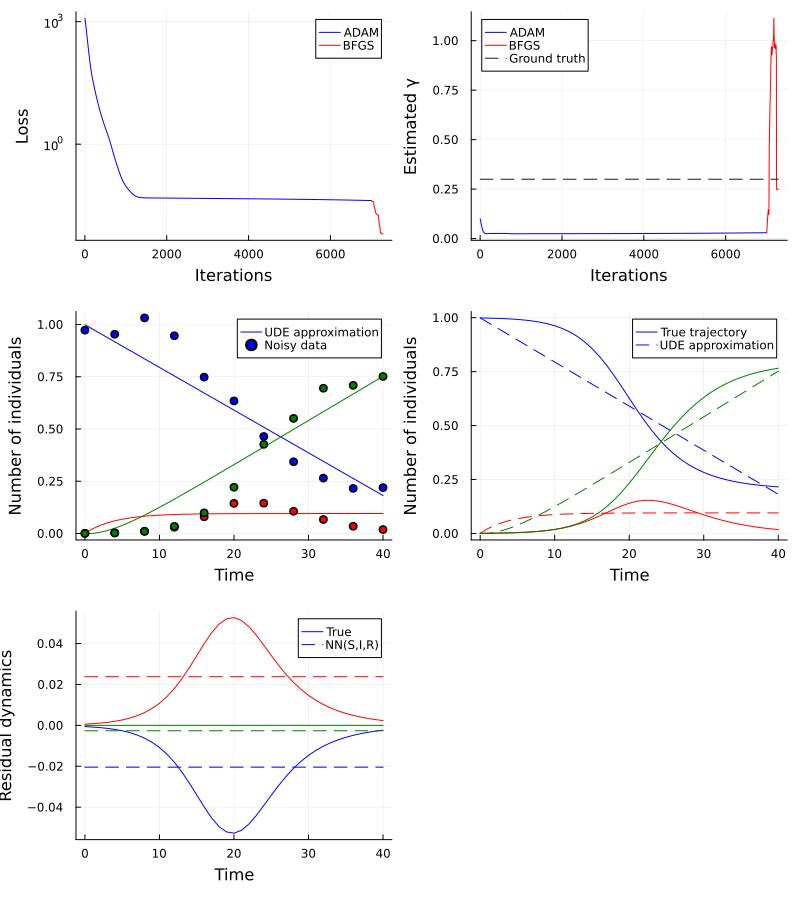

In [13]:
visualize(train_ude("L2 θ", 0.01, 7000, 7500))

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606


Regularization: L2 θ advanced, ω: 0.01
Estimate of γ: 0.24940101990347302
NRMSE of learned residual dynamics: 0.1379361954015655


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\henry\.julia\packages\SciMLBase\s9wrq\src\integrator_interface.jl:606


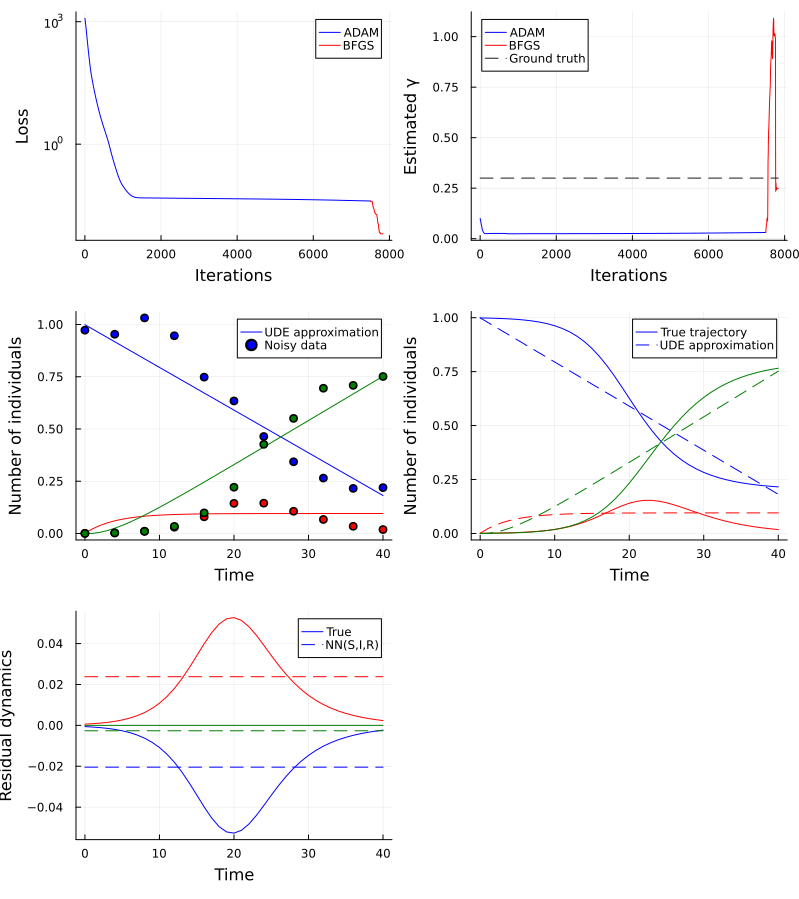

In [14]:
visualize(train_ude("L2 θ advanced", 0.01, 7500, 7500))